In [1]:
import scipy.io.wavfile
from scipy.fftpack import dct
import numpy as np
import glob
import os
import shutil
import matplotlib.pyplot as plt


In [13]:
#Parameter
frame_size = 0.04
frame_stride = 0.026
NFFT = 512
numberOfMelFilter = 32

dataset_loc = './../google_audioset/googleData/unbalanced' #'./../data/final_pre_dataset'
out_folder = './../google_audioset/googleData/fft/unbalanced_fft_mel_l'+str(frame_size)[2:]+"_o"+str(frame_stride)[2:]+"_f"+str(numberOfMelFilter) #'./../data/dataset_fft_mel_noAmplify_l'+str(frame_size)[2:]+"_o"+str(frame_stride)[2:]+"_f"+str(numberOfMelFilter)

sampleRate = 44100
resultingLength = int(np.ceil(float(np.abs(10*sampleRate - frame_size*sampleRate)) / (frame_stride*sampleRate)))
print(resultingLength)

384


In [15]:
def getFilterBank(sample_rate, nfilt):
    low_freq_mel = 0
    high_freq_mel = (2595 * np.log10(1 + (sample_rate / 2) / 700))  # Convert Hz to Mel
    mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Equally spaced in Mel scale
    hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel to Hz
    bin = np.floor((NFFT + 1) * hz_points / sample_rate)

    fbank = np.zeros((nfilt, int(np.floor(NFFT / 2 + 1))))
    for m in range(1, nfilt + 1):
        f_m_minus = int(bin[m - 1])   # left
        f_m = int(bin[m])             # center
        f_m_plus = int(bin[m + 1])    # right

        for k in range(f_m_minus, f_m):
            fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
        for k in range(f_m, f_m_plus):
            fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
    return fbank

def getFrames(signal, sample_rate):
    frame_length, frame_step = frame_size * sample_rate, frame_stride * sample_rate  # Convert from seconds to samples
    signal_length = len(signal)
    frame_length = int(round(frame_length))
    frame_step = int(round(frame_step))
    num_frames = int(np.ceil(float(np.abs(signal_length - frame_length)) / frame_step))  # Make sure that we have at least 1 frame

    pad_signal_length = num_frames * frame_step + frame_length
    z = np.zeros((pad_signal_length - signal_length))
    pad_signal = np.append(signal,z) # Pad Signal to make sure that all frames have equal number of samples without truncating any samples from the original signal

    indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
    frames = pad_signal[indices.astype(np.int32, copy=False)]
    frames *= np.hamming(frame_length)
    time = np.linspace(0,int(len(signal)/sample_rate), num_frames)
    return frames, time

def getMelFilteredFreqs(filename, nFilter, reduceNoise = True, amplifyHighFreqs = True):
    sample_rate, signal = scipy.io.wavfile.read(filename)  # File assumed to be in the same directory
    if len(signal)==0:
        print(filename)
        return None, None
    if amplifyHighFreqs:
        pre_emphasis = 0.97
        signal = np.append(signal[0], signal[1:] - pre_emphasis * signal[:-1])
    frames, time = getFrames(signal, sample_rate)
    
    mag_frames = np.absolute(np.fft.rfft(frames, NFFT))  # Magnitude of the FFT
    pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))  # Power Spectrum

    fbank=getFilterBank(sample_rate, nFilter)
    
    melFiltered_signal = np.dot(pow_frames, fbank.T)
    melFiltered_signal = np.where(melFiltered_signal == 0, np.finfo(float).eps, melFiltered_signal)  # Numerical Stability
    melFiltered_signal = 20 * np.log10(melFiltered_signal)  # dB
    if reduceNoise:
        melFiltered_signal -= (np.mean(melFiltered_signal, axis=0) + 1e-8)
    return melFiltered_signal, time

def plot_fft(fft, name):
    fig, ax = plt.subplots(figsize=(6.4, 3.6))
    fig.patch.set_facecolor('white')
    ax.imshow(fft, origin="lower", aspect="auto")
    # use Time instead of window number. Uncomment line to use window number. 
    #ax.xaxis.set_major_formatter(lambda val, _: times[int(val)] if int(val) >= 0 and int(val) <= len(times) else '')
    plt.xlabel("Zeit")
    plt.ylabel("Frequenzband")
    plt.title("Frequenzen in {}".format(name))
    plt.tight_layout()

In [ ]:
if os.path.exists(out_folder):
    shutil.rmtree(out_folder)
os.makedirs(out_folder)
os.makedirs(out_folder + '/dev')
os.makedirs(out_folder + '/eval')
shutil.copyfile(dataset_loc+"/dev-labels.csv", out_folder+"/dev-labels.csv")

print('===', 'Processing training files', '============')

# train files
train_files = sorted([x.split('\\')[-1] for x in glob.glob(f'{dataset_loc}/dev/*.wav')])
max_len = len(train_files)

# load and save train files (we could pass the full array to the function, but not everyone might have the mem space to do so)
for i, file_name in enumerate(train_files):
    if i % 1000 == 0 and i!=0:
        print(i, '/', max_len)
    # load
    train_feats, train_times = getMelFilteredFreqs(file_name, numberOfMelFilter, reduceNoise = True, amplifyHighFreqs = False)
    if train_feats==None or train_times==None:
        continue
    # merge time and fft
    tmp = np.concatenate([np.expand_dims(train_times, axis=1), train_feats], axis=1)
    # save to csv
    name = file_name.split('/')[-1]
    np.savetxt(out_folder + '/dev/' + name.replace('.wav', '.csv'), tmp, delimiter=',')

plot_fft(tmp.T, name)

In [10]:
print('===', 'Processing evaluation files', '============')

# load eval files
eval_files = sorted([x.split('\\')[-1] for x in glob.glob(f'{dataset_loc}/eval/*.wav')])
max_len = len(eval_files)

# save eval files
for i, file_name in enumerate(eval_files):
    if i % 1000 == 0:
        print(i, '/', max_len)
    eval_feats, eval_times = getMelFilteredFreqs(file_name, numberOfMelFilter)
    # merge time and fft
    tmp = np.concatenate([np.expand_dims(eval_times, axis=1), eval_feats], axis=1)
    # save to csv
    name = file_name.split('/')[-1]
    np.savetxt(out_folder + '/eval/' + name.replace('.wav', '.csv'), tmp, delimiter=',')

=== Processing evaluation files ============
0 / 3000
1000 / 3000
2000 / 3000


# Google Audioset

=== Processing training files ============
1000 / 17551
2000 / 17551
3000 / 17551
4000 / 17551
5000 / 17551
6000 / 17551
7000 / 17551
8000 / 17551
9000 / 17551
10000 / 17551
11000 / 17551
12000 / 17551
13000 / 17551
14000 / 17551
15000 / 17551
16000 / 17551
17000 / 17551


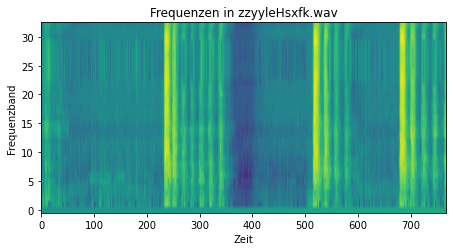

In [19]:
if os.path.exists(out_folder):
    shutil.rmtree(out_folder)
os.makedirs(out_folder)

print('===', 'Processing training files', '============')

# train files
train_files = sorted([x.split('\\')[-1] for x in glob.glob(f'{dataset_loc}/*.wav')]) 
max_len = len(train_files)

# load and save train files (we could pass the full array to the function, but not everyone might have the mem space to do so)
for i, file_name in enumerate(train_files):
    if i % 1000 == 0 and i!=0:
        print(i, '/', max_len)
    # load
    train_feats, train_times = getMelFilteredFreqs(file_name, numberOfMelFilter, reduceNoise = True, amplifyHighFreqs = True)
    # merge time and fft
    tmp = np.concatenate([np.expand_dims(train_times, axis=1), train_feats], axis=1)
    # save to csv
    name = file_name.split('/')[-1]
    np.savetxt(out_folder + '/' + name.replace('.wav', '.csv'), tmp, delimiter=',') 
plot_fft(tmp.T, name)